<a href="https://colab.research.google.com/github/alexk2206/Data_Driven_Fantasy_Football/blob/dev/First.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import pandas as pd
#!pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [60]:
# Load the CSV file, skipping problematic lines

file_path = '/content/FantasyPros_2024_Overall_ADP_Rankings.csv'
df = pd.read_csv(file_path, on_bad_lines='skip')  # or 'warn'

# Convert AVG to float
df['AVG'] = pd.to_numeric(df['AVG'], errors='coerce')

# Nonlinear value calculation
k = 0.02  # Adjust this value for steeper or flatter curves
df['Value'] = 1000 * np.exp(-k * (df['AVG'] - 1))
df['POS'] = df['POS'].str.replace('\d+', '', regex=True)

# Show some results
#players_df = players_df.sort_values(by='Value', ascending=False)
df

POS
WR     72
RB     58
QB     26
TE     25
DST    21
K      18
Name: count, dtype: int64


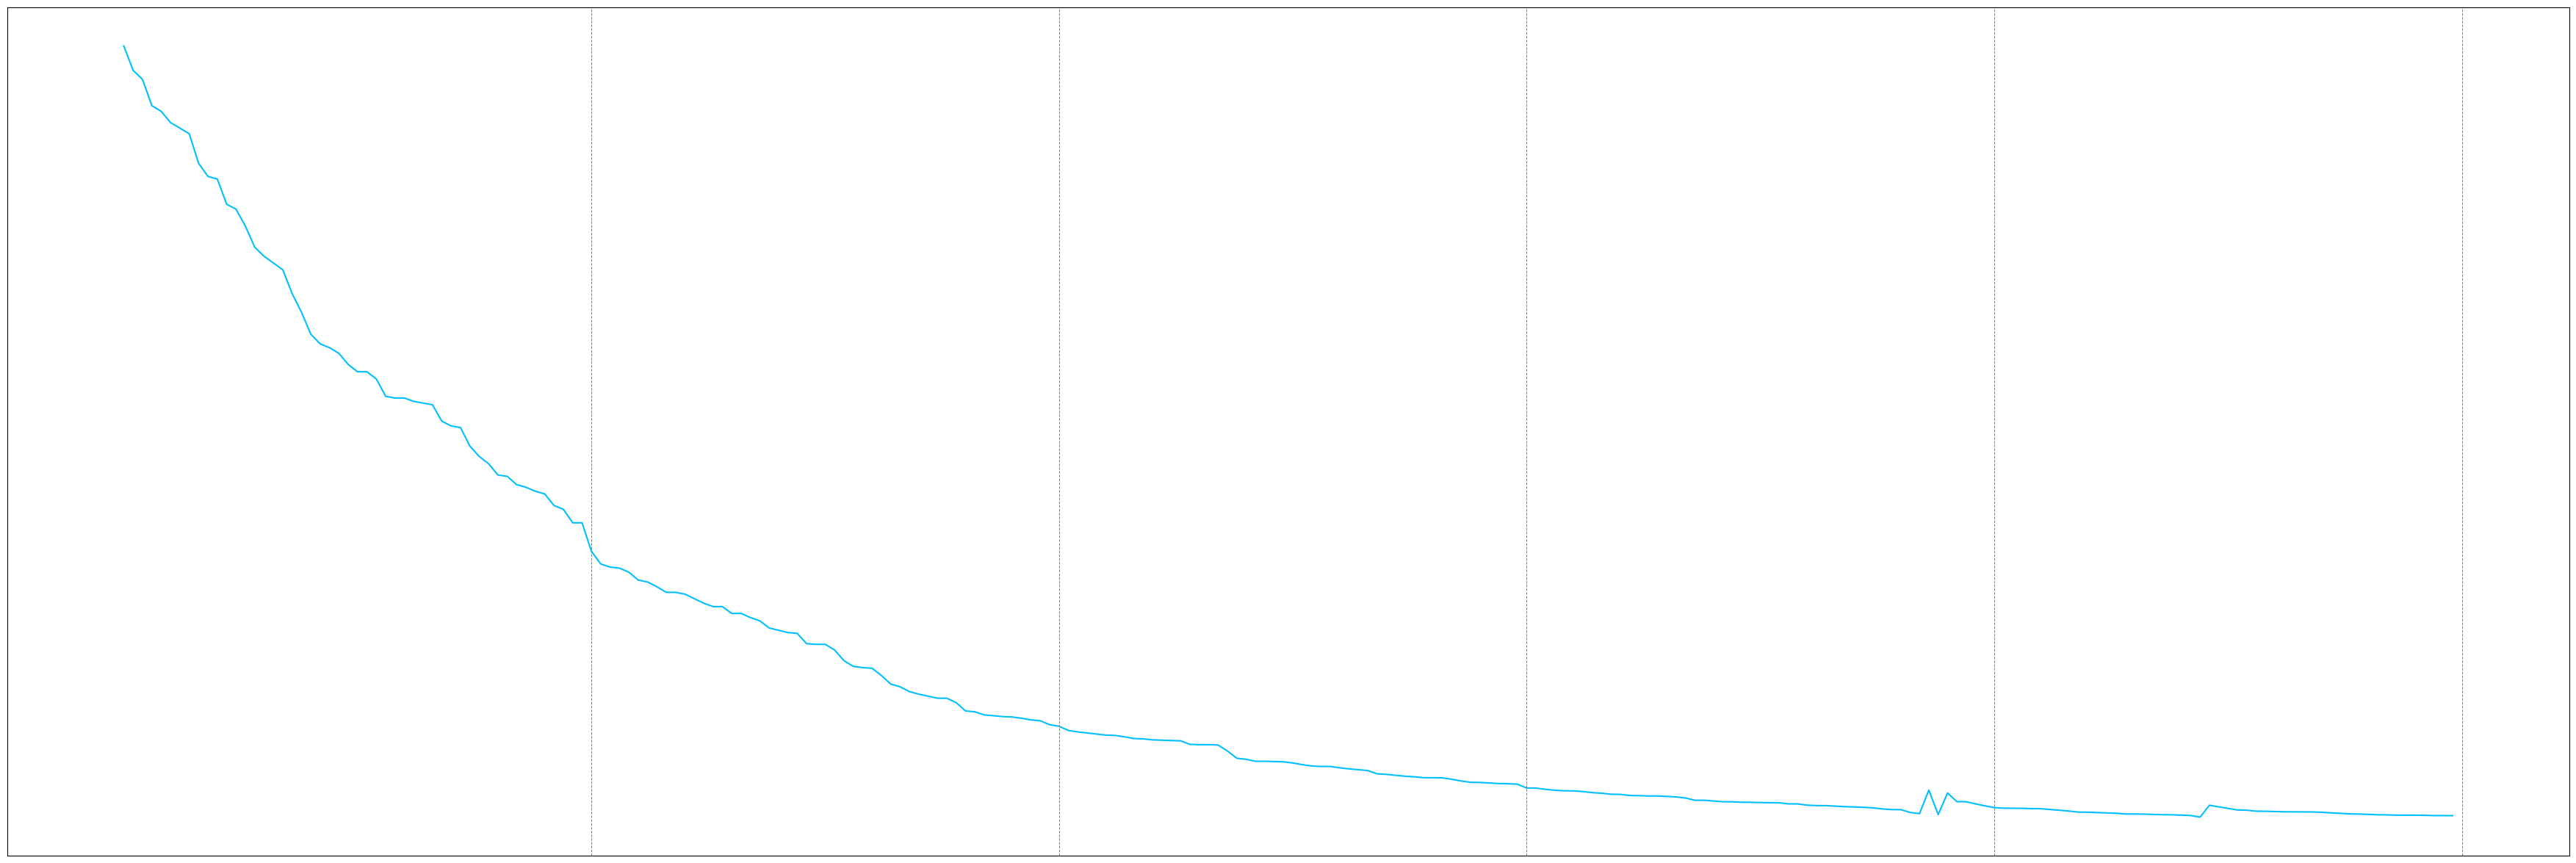

In [41]:
import matplotlib.pyplot as plt
# Plot the first 250 entries
plt.figure(figsize=(45, 15))
plt.plot(df['Value'].iloc[:250], color='deepskyblue')

# Add vertical lines every 50 entries
for x in range(50, 251, 50):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.7)

# Remove axis labels
plt.xticks([])
plt.yticks([])

plt.show()


In [67]:
df = df[['Player', 'POS', 'Value']].dropna()

# Only keep relevant positions
df = df[df['POS'].str.contains('QB|RB|WR|TE|K|DST', na=False)]

df_small = df.nlargest(220, 'Value').copy()

print(df_small['Player'].duplicated().sum())
print(df_small['POS'].value_counts())
print(df_small.head(20))

0
POS
WR     72
RB     58
QB     26
TE     25
DST    21
K      18
Name: count, dtype: int64
                 Player POS        Value
0   Christian McCaffrey  RB  1000.000000
1           CeeDee Lamb  WR   968.506582
2           Tyreek Hill  WR   956.953957
3        Bijan Robinson  RB   923.116346
4           Breece Hall  RB   915.760877
5     Amon-Ra St. Brown  WR   901.225297
6         Ja'Marr Chase  WR   894.044258
7      Justin Jefferson  WR   886.920437
8        Saquon Barkley  RB   848.742022
9            A.J. Brown  WR   831.935804
10      Jonathan Taylor  RB   828.614707
11       Garrett Wilson  WR   796.124260
12         Jahmyr Gibbs  RB   789.780674
13           Puka Nacua  WR   767.973540
14       Kyren Williams  RB   740.818221
15  Marvin Harrison Jr.  WR   729.059450
16   Travis Etienne Jr.  RB   720.363020
17        Derrick Henry  RB   711.770323
18        Isiah Pacheco  RB   681.131427
19        Davante Adams  WR   657.046820


In [73]:
players = df_small.to_dict('records')
num_teams = 4
roster = {'QB': 1, 'RB': 2, 'WR': 2, 'TE': 1, 'K': 1, 'DST': 1}
bench = 8
roster_size = sum(roster.values()) + bench

# Helper to normalize position
def pos_cat(pos):
    pos = pos.strip().upper()
    if pos.startswith('QB'):
        return 'QB'
    if pos.startswith('RB'):
        return 'RB'
    if pos.startswith('WR'):
        return 'WR'
    if pos.startswith('TE'):
        return 'TE'
    if pos.startswith('K'):
        return 'K'
    if pos.startswith('DST'):
        return 'DST'
    return None

# Build position map for each player
pos_map = {p['Player']: pos_cat(p['POS']) for p in players}

# Start Gurobi model
m = gp.Model('fantasy_draft_12_teams')

# Binary variable: x[player, team] == 1 if player assigned to team
x = {}
for p in players:
    for t in range(num_teams):
        x[(p['Player'], t)] = m.addVar(vtype=GRB.BINARY, name=f"{p['Player']}_team{t}")

m.update()

# Objective: maximize total value
m.setObjective(
    gp.quicksum(p['Value'] * x[(p['Player'], t)] for p in players for t in range(num_teams)),
    GRB.MAXIMIZE
)

# Each player can only be on one team
for p in players:
    m.addConstr(gp.quicksum(x[(p['Player'], t)] for t in range(num_teams)) <= 1)

# For each team t:
for t in range(num_teams):
    # Strict starter constraints
    m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players if p['POS'] == 'QB') == 1)
    m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players if p['POS'] == 'RB') == 2)
    m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players if p['POS'] == 'WR') == 2)
    m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players if p['POS'] == 'TE') == 1)
    m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players if p['POS'] == 'K') == 1)
    m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players if p['POS'] == 'DST') == 1)
    # Total roster size (starters + bench)
    m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players) == roster_size)

m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players if p['POS'] == 'QB') <= 3)


# Add bench limits for each team and position
bench_limits = {'QB': 2, 'RB': 6, 'WR': 6, 'TE': 3, 'K': 2, 'DST': 2}
for t in range(num_teams):
    for pos, max_count in bench_limits.items():
        m.addConstr(gp.quicksum(x[(p['Player'], t)] for p in players if p['POS'] == pos) <= max_count)

# Solve
m.optimize()

if m.Status == GRB.OPTIMAL or m.Status == GRB.TIME_LIMIT:
    teams = {t: [] for t in range(num_teams)}
    for p in players:
        for t in range(num_teams):
            if x[(p['Player'], t)].X > 0.5:
                teams[t].append({'Player': p['Player'], 'POS': p['POS'], 'Value': p['Value']})
    for t in range(num_teams):
        print(f"\nTeam {t+1} (Total Value: {sum(p['Value'] for p in teams[t]):.2f}):")
        for p in teams[t]:
            print(f"  {p['Player']:25} {p['POS']:6} {p['Value']:.1f}")
else:
    print("No feasible solution found. Model status:", m.Status)
    m.computeIIS()
    m.write("model.ilp")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 273 rows, 880 columns and 3546 nonzeros
Model fingerprint: 0xe72ccbcd
Variable types: 0 continuous, 880 integer (880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 25 rows and 0 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
No feasible solution found. Model status: 3
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @

In [72]:
from gurobipy import GRB

# After m.optimize()
if m.Status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    m.computeIIS()
    m.write("model.ilp")  # Writes the IIS to a file for inspection
    print("IIS written to model.ilp")
else:
    print("Model is feasible or optimal. No IIS needed.")


Model is infeasible. Computing IIS...
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


IIS computed: 7 constraints, 0 bounds
IIS runtime: 0.00 seconds (0.00 work units)
IIS written to model.ilp
